# Homework 7 solutions

We want to solve the diffusion equation using implicit Crank-Nicolson time integration.

We can reuse the backward-difference implicit solver from class, and we just need to change a few things.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The grid class is unchanged.

In [2]:
class Grid:
    """ a simple class to hold cell-centered finite-difference  /
    finite-volume data """

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = np.zeros((nx+2*ng), dtype=np.float64)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the ghostcells with zero gradient (Neumann)
            boundary conditions """
        self.phi[0:self.ilo] = self.phi[self.ilo]
        self.phi[self.ihi+1:] = self.phi[self.ihi]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

We'll use the same test problem as before: a Gaussian profile.

In [3]:
def gaussian_ic(g, k, t=0.0, t0=1.e-4, phi1=1.0, phi2=2.0):
    xc = 0.5*(g.xmin + g.xmax)
    return (phi2 - phi1) * (np.sqrt(t0/(t + t0)) *
                            np.exp(-0.25 * (g.x - xc)**2 / (k * (t + t0)))) + phi1

In [4]:
from scipy import linalg

To allow for comparison, here's the first-order backward-Euler method

In [5]:
def implicit_step_be(gr, phi, k, dt):
    """ diffuse phi implicitly through timestep dt using backward-Euler"""

    phinew = gr.scratch_array()

    alpha = k * dt / gr.dx**2

    # create the RHS of the matrix
    R = phi[gr.ilo:gr.ihi+1]

    # create the diagonal, d+1 and d-1 parts of the matrix
    d = (1.0 + 2.0*alpha)*np.ones(gr.nx)

    u = -alpha*np.ones(gr.nx)
    u[0] = 0.0

    l = -alpha*np.ones(gr.nx)
    l[-1] = 0.0

    # set the boundary conditions by changing the matrix elements

    # homogeneous neumann
    d[0] = 1.0 + alpha
    d[-1] = 1.0 + alpha

    # solve
    A = np.matrix([u, d, l])

    phinew[gr.ilo:gr.ihi+1] = linalg.solve_banded((1, 1), A, R)

    return phinew


and here's the Crank-Nicolson method.  The changes from backward-Euler are:

* the righthand side array, `R`, now has the explicit diffusion term added
* the matrix elements `d`, `u`, and `l` are all changed

In [6]:
def implicit_step_cn(gr, phi, k, dt):
    """ diffuse phi implicitly through timestep dt """

    phinew = gr.scratch_array()

    alpha = k * dt / gr.dx**2

    # create the RHS of the matrix
    gr.fill_BCs()
    
    R = phi[gr.ilo:gr.ihi+1] + 0.5 * alpha * (phi[gr.ilo+1:gr.ihi+2] - 2.0 * phi[gr.ilo:gr.ihi+1] + phi[gr.ilo-1:gr.ihi])

    # create the diagonal, d+1 and d-1 parts of the matrix
    d = (1.0 + alpha)*np.ones(gr.nx)

    u = -0.5 * alpha * np.ones(gr.nx)
    u[0] = 0.0

    l = -0.5 * alpha * np.ones(gr.nx)
    l[-1] = 0.0

    # set the boundary conditions by changing the matrix elements

    # homogeneous neumann
    d[0] = 1.0 + 0.5 * alpha
    d[-1] = 1.0 + 0.5 * alpha

    # solve
    A = np.matrix([u, d, l])
    phinew[gr.ilo:gr.ihi+1] = linalg.solve_banded((1, 1), A, R)

    return phinew

Here's the main loop.  The main difference now, compared to what we did previously
is that our grid has 1 ghostcell (instead of 0) and we will the boundary conditions
ever step.  This is needed because we need to compute the second-derivative term
as part of the righthand side that enters the matrix solve.

In [7]:
def diffuse_implicit(nx, k, C, tmax, init_cond, method="CN"):
    """
    the main evolution loop.  Evolve

     phi_t = k phi_{xx}

    from t = 0 to tmax
    """

    # create the grid
    ng = 1
    
    g = Grid(nx, ng)

    # time info
    dt = C * 0.5 *g.dx**2 / k
    t = 0.0

    # initialize the data
    g.phi[:] = init_cond(g, k)

    while t < tmax:

        g.fill_BCs()
        
        # make sure we end right at tmax
        if t + dt > tmax:
            dt = tmax - t

        # diffuse for dt
        if method == "CN":
            phinew = implicit_step_cn(g, g.phi, k, dt)
        elif method == "BE":
            phinew = implicit_step_be(g, g.phi, k, dt)
        else:
            raise ValueError(f"unknown method: {method}")
            
        g.phi[:] = phinew[:]
        t += dt

    return g

Let's estimate the diffusion time across a single cell

In [8]:
nx = 128

k = 1

t_diffuse = (1.0/nx)**2 / k

Now let's see how the new method does with different timesteps

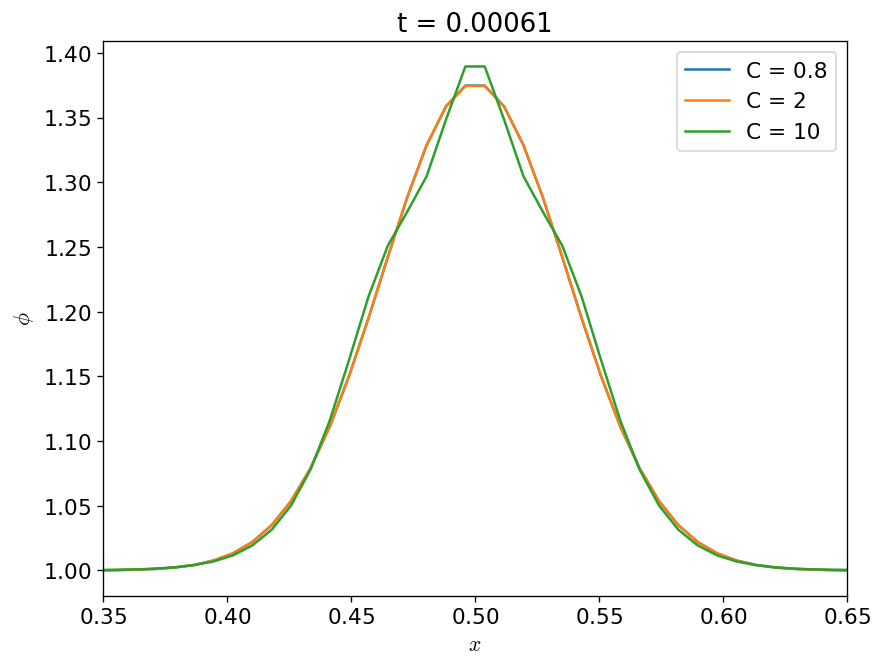

In [9]:
fig, ax = plt.subplots()

tmax = 10 * t_diffuse

for C in [0.8, 2, 10]:
    g = diffuse_implicit(nx, k, C, tmax, gaussian_ic, method="CN")
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"C = {C}")

ax.set_xlim(0.35, 0.65)
ax.set_xlabel("$x$")
ax.set_ylabel("$\phi$")

ax.set_title(f"t = {tmax:7.3g}")
ax.legend()

Finally, let's compare the convergence of the original backward-Euler and the new Crank-Nicolson methods

In [10]:
nx_reference = 64
t_diffuse = (1.0/nx_reference)**2 / k

Text(0, 0.5, 'absolute error')

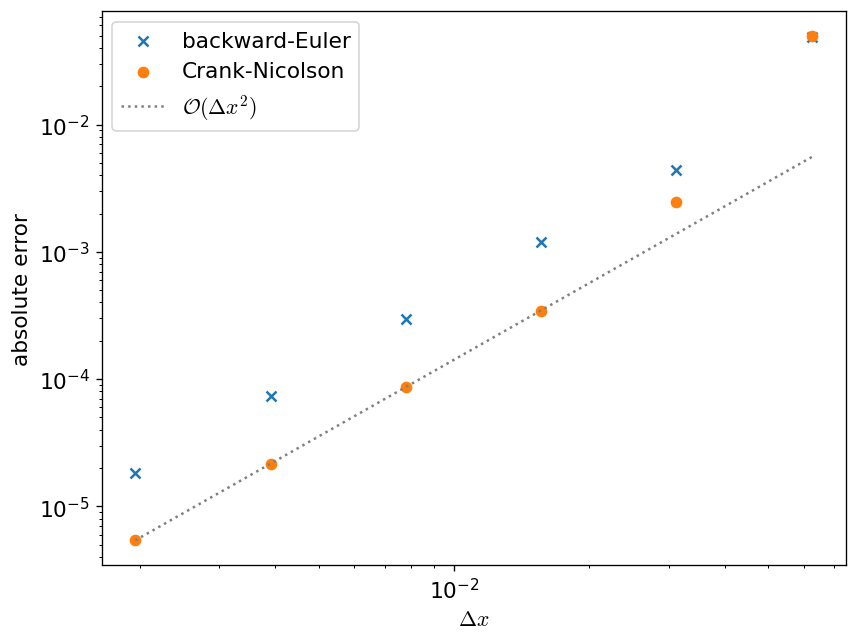

In [11]:
fig, ax = plt.subplots()

Ns = [16, 32, 64, 128, 256, 512]
dxs = []
be_errors = []
cn_errors = []

tmax = 10 * t_diffuse
C = 0.8

for nx in Ns:
    g_be = diffuse_implicit(nx, k, C, tmax, gaussian_ic, method="BE")
    g_cn = diffuse_implicit(nx, k, C, tmax, gaussian_ic, method="CN")
    phi_analytic = gaussian_ic(g_be, k, t=tmax)
    dxs.append(g_be.dx)
    be_errors.append(g_be.norm(g_be.phi - phi_analytic))
    cn_errors.append(g_cn.norm(g_cn.phi - phi_analytic))
    
ax.scatter(dxs, be_errors, marker="x", label="backward-Euler")
ax.scatter(dxs, cn_errors, marker="o", label="Crank-Nicolson")

ideal = cn_errors[-1] * np.array(dxs)**2 / dxs[-1]**2

ax.plot(dxs, ideal, color="0.5", ls=":", label=r"$\mathcal{O}(\Delta x^2)$")

ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel("absolute error")

We see that the Crank-Nicolson method is more accurate, but both converge 2nd-order
overall.